# Analysis of How Restart Incremental Models Construct Meaning Representations Step by Step

In this notebook, we analyse the states built by the restart-incremental pretrained language models on various types of temporary ambiguities.

In [1]:
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from incstates import IncStatesAnalyser
from utils import detect_added_positions, add_emtpy_row_column, crop_chart, NNC_TEMPLATE, tokenize, METRIC

from sklearn.metrics.pairwise import paired_distances

/tmp/ipykernel_2096279/1065993689.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/users/blasota/anaconda3/envs/restart-inc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = './outputs/preprocessed_stimuli.csv'

MODEL = 'bert'
N_LAYERS = 13

STATES_PATH = './outputs/embeddings/'
TRIANGLES_PATH = './outputs/triangles/'

NNC_REFERENCE = 'previous'
NPS_REFERENCE = 'last'
MVRR_REFERENCE = 'last'

SELECTED_LAYER = 9

COLS = cols = ['noun', 'verb 1', 'det', 'noun', 'verb 2', '...', '...', '...', '...', '...']

USE_ABS = True

In [3]:
data_df = pd.read_csv(DATA_PATH, index_col=0)

In [4]:
def dist_func(*x):
    """Return a specific distance function between two vectors."""
    return paired_distances(*x, metric=METRIC) 


def get_prisms_triangles(source):
    with h5py.File(Path(f'{STATES_PATH}{MODEL}_{source}_embeddings.h5'), 'r') as f:
        prisms = {key: value[:] for key, value in f.items()}

    with h5py.File(Path(f'{TRIANGLES_PATH}{MODEL}_{source}_{METRIC}.h5'), 'r') as f:
        triangles = {key: value[:] for key, value in f.items()}
    return prisms, triangles


def get_both_additions(source, stimulus, baseline):
    if source == 'nnc':
        # we will remove the last token of the stimulus in this case
        # to make the dimensions match with baseline containing that instead of
        # second noun
        additions_stimulus = [len(stimulus.split()) - 1]
        additions_baseline = None
    elif source in ('classic-nps', 'classic-mvrr'):
        # we will remove the tokens added to disambiguate in advance
        additions_stimulus = None
        additions_baseline = detect_added_positions(stimulus.split(), baseline.split())
    else:
        raise NotImplementedError
    return additions_stimulus, additions_baseline


def get_objects(source, df, prisms, triangles, reference):
    objs = {}

    for idx, row in df.iterrows():
        # some sentences were not processed due to subtokenization
        if f'{idx}_baseline' not in prisms:
            continue
        objs[idx] = {}

        baseline, stimulus = row.baseline, row.stimulus
        additions_stimulus, additions_baseline = get_both_additions(source,
                                                                    stimulus,
                                                                    baseline)

        stimulus_states = prisms[f'{idx}_stimulus']
        obj_stimulus = IncStatesAnalyser(stimulus,
                                         states=stimulus_states,
                                         modes=[reference],
                                         additions=additions_stimulus,
                                         tokenized=True)
        inc_charts = triangles[f'{idx}_stimulus_{reference}']
        obj_stimulus.inc_charts = {reference: inc_charts}
        objs[idx]['stimulus'] = obj_stimulus

        baseline_sent_states = prisms[f'{idx}_baseline']
        obj_baseline = IncStatesAnalyser(baseline,
                                         states=baseline_sent_states,
                                         modes=[reference],
                                         additions=additions_baseline,
                                         tokenized=True)
        inc_charts = triangles[f'{idx}_baseline_{reference}']
        obj_baseline.inc_charts = {reference: inc_charts}
        objs[idx]['baseline'] = obj_baseline
    
    return objs


def get_diff(x, y):
    if USE_ABS == True:
        return np.abs(x - y)
    return x - y

## Analysis NNC

For the NNC stimuli, the final meaning of the stimuli and its baseline are different, so we won't make comparisons to the last time step. We are mostly interested in the effect that the second noun has on the first one, so we focus on comparisons to previous time steps. 

In [5]:
nnc_df = data_df[data_df.source=='nnc']
nnc_prisms, nnc_triangles = get_prisms_triangles('nnc')

nnc_objs = get_objects('nnc', nnc_df, nnc_prisms, nnc_triangles, NNC_REFERENCE)

standard_tokens = tokenize(NNC_TEMPLATE.substitute(nnc='noun1 noun2'))

Reorganise charts by layer. We also compute the absolute difference between the sentence with the NNC with respect to the baseline.

In [6]:
nnc_stimuli_triangles = {i: {} for i in range(N_LAYERS)}
nnc_baseline_triangles = {i: {} for i in range(N_LAYERS)}
nnc_diffs = {i: {} for i in range(N_LAYERS)}

for idx, objs in nnc_objs.items():
    obj_stimulus = objs['stimulus']
    obj_baseline = objs['baseline']

    for layer in range(N_LAYERS):
        stimulus_chart = obj_stimulus.get_mode_layer_chart(NNC_REFERENCE, layer)
        baseline_chart = obj_baseline.get_mode_layer_chart(NNC_REFERENCE, layer)

        # add one empty row and one emtpy col just to align visualisation
        baseline_chart_ext = add_emtpy_row_column(baseline_chart)

        stimulus_short_chart = obj_stimulus.get_mode_layer_chart(
            NNC_REFERENCE, layer, remove_additions=True)
        diff = get_diff(stimulus_short_chart, baseline_chart)

        nnc_stimuli_triangles[layer][idx] = stimulus_chart
        nnc_baseline_triangles[layer][idx] = baseline_chart_ext
        nnc_diffs[layer][idx] = diff

Create a dataframe containing the absolute differences at the second noun, to facilitate plotting.

In [7]:
dfs = []

for layer, layer_charts in nnc_diffs.items():
    # only the last time step in diff, and ignore the recently added continuation
    layer_diffs = [np.expand_dims(chart[-1][:-1], 0) for chart in layer_charts.values()]
    all_diffs = np.vstack(layer_diffs)
    df = pd.DataFrame(all_diffs)
    df['layer'] = layer
    dfs.append(df)

dfs = pd.concat(dfs)
col_names = {idx: token for idx, token in enumerate(standard_tokens)}
dfs.rename(columns=col_names, inplace=True)

In [8]:
dfs.groupby('layer').mean()

This        is       the     noun1
layer                                        
0      0.000000  0.000000  0.000000  0.000000
1      0.006677  0.012065  0.004726  0.058772
2      0.005192  0.007532  0.003623  0.081480
3      0.004737  0.006908  0.013211  0.111597
4      0.007147  0.009891  0.025582  0.132041
5      0.012593  0.014448  0.039529  0.148983
6      0.020358  0.019563  0.053701  0.148971
7      0.024285  0.023253  0.050018  0.149659
8      0.034965  0.031100  0.060537  0.130005
9      0.052589  0.040982  0.068414  0.125001
10     0.061364  0.050287  0.073387  0.115395
11     0.060088  0.045845  0.072429  0.103281
12     0.068840  0.055116  0.075257  0.117108

Plot how distant is the state of each token is from its states in the previous time step. This shows the effect of the latest right token on each token in the prefix. We have subtracted from it a "neutral" continuation where the first noun remains an NP to account for the natural variation that would occur when adding right context. We interpret the difference to be the effect of the new interpretation that the second noun assigns to the first noun. We plot the average and error over all nnc stimuli for each layer.

In [9]:
dfs = dfs.melt(id_vars=['layer'], var_name='token', value_name=f'{METRIC} distance')

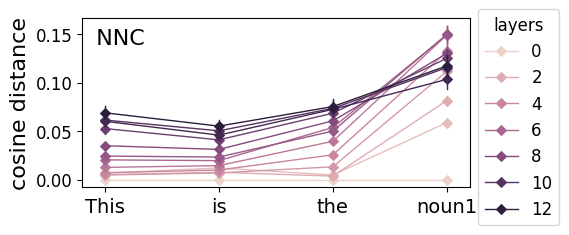

In [10]:
fig, ax = plt.subplots(figsize=(5, 2.2))
sns.pointplot(data=dfs,
              x='token', y=f'{METRIC} distance',
              hue='layer',
              marker="D",
              linewidth=1,
              markersize=5,
              ax=ax, 
              #errorbar='sd', #'pi', 'se', 'ci', 
              #legend='full'
              )

ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=12)
plt.xlabel('  NNC', loc='left', labelpad=-135, fontsize=16)
plt.ylabel(f'{METRIC} distance', fontsize=16)
plt.legend(title='layers', fontsize=12, title_fontsize=12,  bbox_to_anchor=(1, 1.1), loc="upper left")
plt.xlim(-0.2, 3.2)

plt.savefig(f'./figures/nnc_avr-variation_{MODEL}_{NNC_REFERENCE}_{METRIC}.pdf', bbox_inches='tight')
plt.show()

Plot overview of how much states change step by step on sitmuli for all layers:

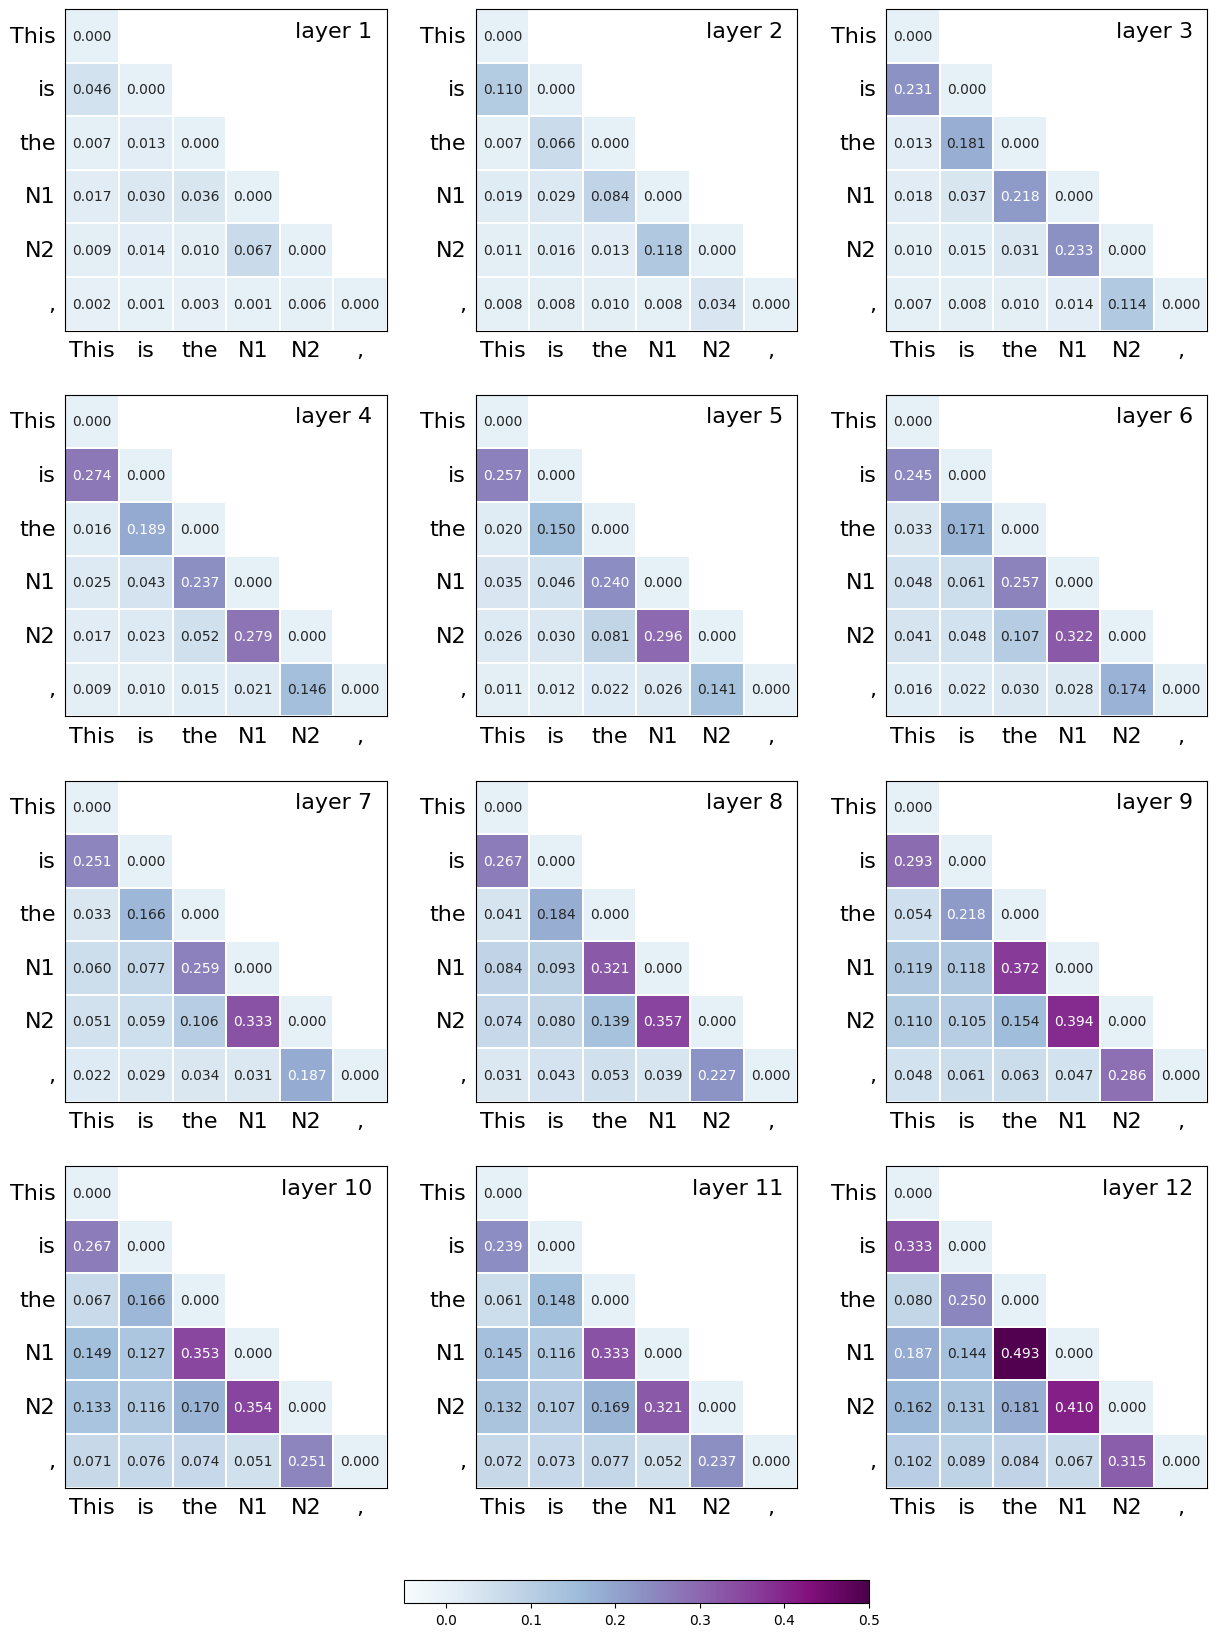

In [11]:
shorten_tokens = standard_tokens[:3] + ['N1', 'N2'] + [standard_tokens[-1]]

vmax = 0.5 if MODEL == 'bert' else 0.13
vmin = -0.05 if MODEL == 'bert' else -0.01

fig, axes = plt.subplots(4, 3, figsize=(15, 24))
 
for layer, ax in zip(range(1, N_LAYERS), axes.flatten()):
    changes = [np.expand_dims(chart, 0) for chart in nnc_stimuli_triangles[layer].values()]
    all_dists = np.vstack(changes)

    means = np.mean(all_dists, axis=0)
    #np.fill_diagonal(means, '-')
    g = sns.heatmap(means,
                    xticklabels=shorten_tokens,
                    yticklabels=shorten_tokens,
                    square=True,
                    cbar=False,
                    cmap="BuPu", # crest, bone_r
                    linewidths=0.1,
                    vmin=vmin, vmax=vmax,
                    annot=True, fmt='.3f', annot_kws={"fontsize": 10},
                    ax=ax)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(left=False, bottom=False)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    ax.set_title(f'layer {layer}  ' , pad=-20, fontsize=16, loc='right')
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

mappable = g.get_children()[0]
fig.colorbar(mappable, ax=axes, orientation="horizontal", shrink=0.4, pad=0.05)

#plt.tight_layout()   
plt.savefig(f'./figures/ncc-overview_{MODEL}_{NNC_REFERENCE}_{METRIC}.pdf', bbox_inches='tight')
plt.show()

In [12]:
for idx, row in nnc_df.iterrows():
    print(idx, row.stimulus)

0 This is the bankruptcy proceeding ,
1 This is the black operation ,
2 This is the field work ,
3 This is the marketing consultant ,
4 This is the box office ,
5 This is the noise complaint ,
6 This is the pipe dream ,
7 This is the honey trap ,
8 This is the acid test ,
9 This is the case study ,
10 This is the chain reaction ,
11 This is the ancient history ,
12 This is the china clay ,
13 This is the divine service ,
14 This is the economic aid ,
15 This is the lip service ,
16 This is the mail service ,
17 This is the computer expert ,
18 This is the cable car ,
19 This is the panda car ,
20 This is the credit card ,
21 This is the basket case ,
22 This is the life belt ,
23 This is the rock bottom ,
24 This is the swimming pool ,
25 This is the public service ,
26 This is the sitting duck ,
27 This is the balance sheet ,
28 This is the cheat sheet ,
29 This is the black cherry ,
30 This is the guinea pig ,
31 This is the human being ,
32 This is the milk tooth ,
33 This is the cu

Examine all plots for one stimulus:

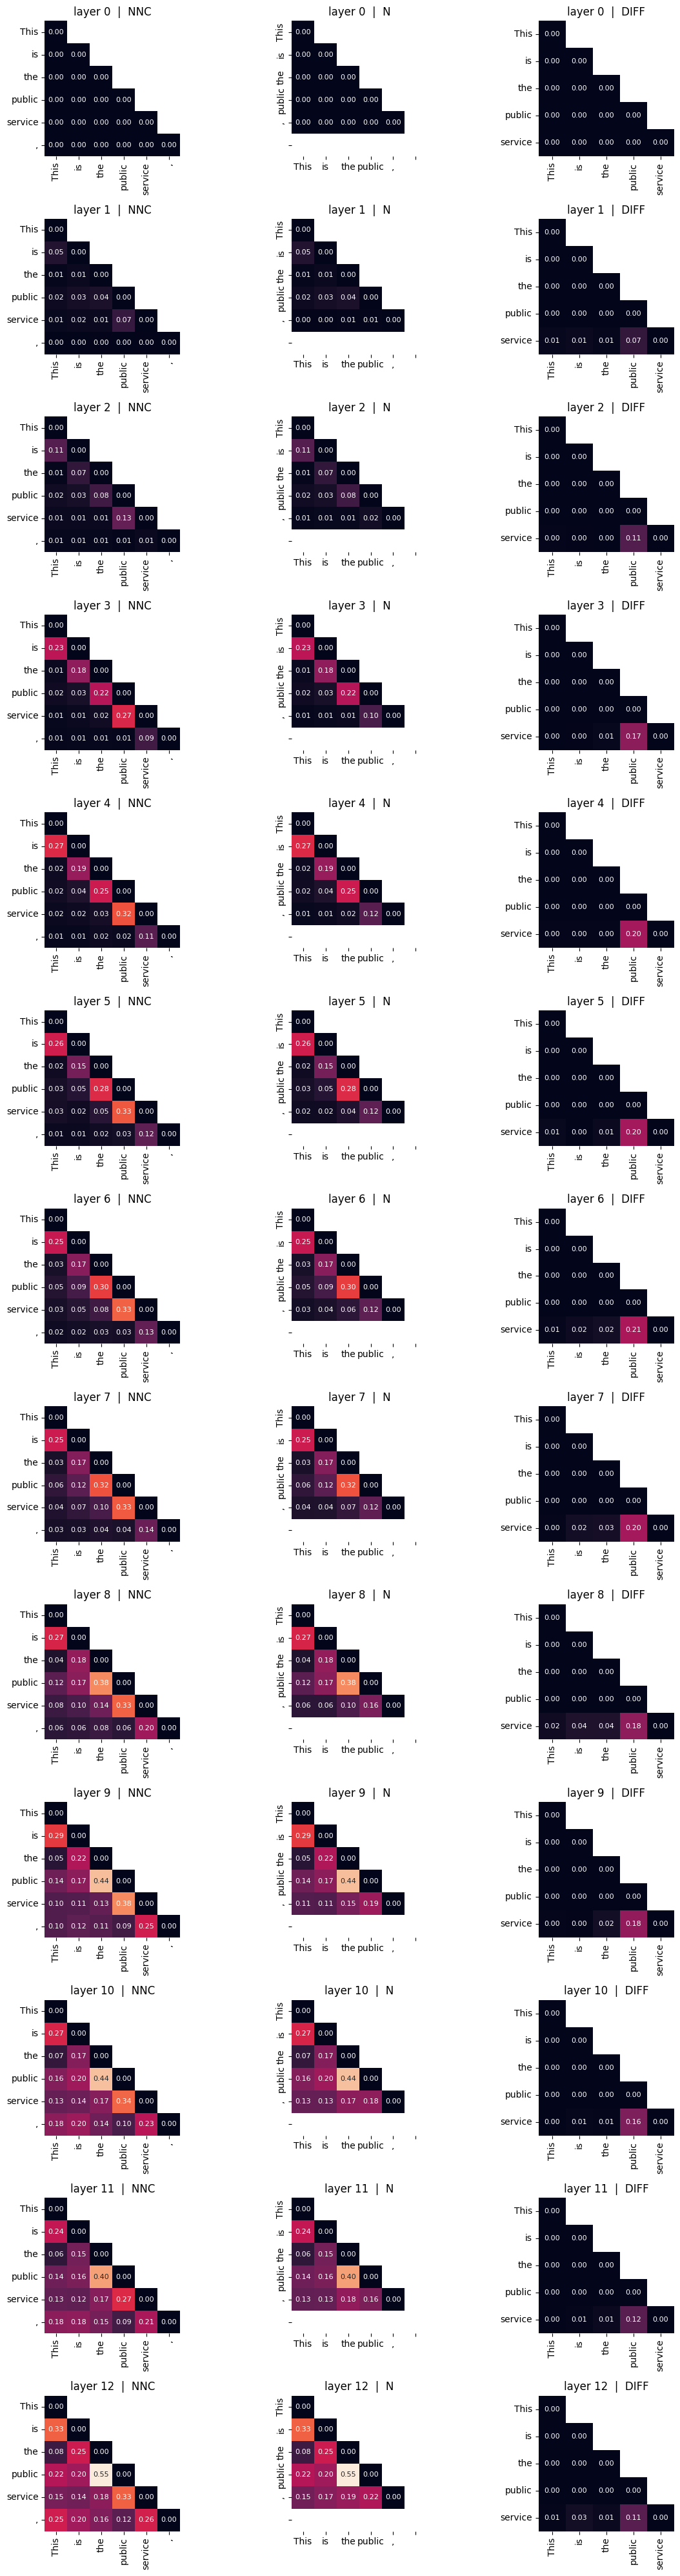

In [13]:
IDX = 25
vmax = 0.5 if MODEL == 'bert' else 0.15

fig, axs = plt.subplots(13, 3, figsize=(12, 40))

for layer, ax in zip(range(N_LAYERS), axs):

    sns.heatmap(nnc_stimuli_triangles[layer][IDX], ax=ax[0],
                xticklabels=nnc_df.loc[IDX].stimulus.split(),
                yticklabels=nnc_df.loc[IDX].stimulus.split(),
                annot=True, fmt='.2f', annot_kws={"fontsize":8},
                vmin=0, vmax=0.5,
                square=True, cbar=False) 

    sns.heatmap(nnc_baseline_triangles[layer][IDX], ax=ax[1],
                xticklabels=nnc_df.loc[IDX].baseline.split() + [''],
                yticklabels=nnc_df.loc[IDX].baseline.split() + [''],
                annot=True, fmt='.2f', annot_kws={"fontsize":8},
                vmin=0, vmax=0.5,
                square=True, cbar=False) 
                
    sns.heatmap(nnc_diffs[layer][IDX], ax=ax[2],
                xticklabels=nnc_df.loc[IDX].stimulus.split()[:-1],
                yticklabels=nnc_df.loc[IDX].stimulus.split()[:-1],
                annot=True, fmt='.2f', annot_kws={"fontsize":8},
                vmin=0, vmax=0.5,
                square=True, cbar=False) 

    ax[0].set_title(f'layer {layer}  |  NNC')
    ax[1].set_title(f'layer {layer}  |  N')
    ax[2].set_title(f'layer {layer}  |  DIFF')

plt.tight_layout()
plt.show()

## Analysis of Classic Garden Paths

### NP/S

In [14]:
nps_df = data_df[data_df.source=='classic-nps']
nps_prisms, nps_triangles = get_prisms_triangles('classic-nps')
nps_objs = get_objects('classic-nps', nps_df, nps_prisms, nps_triangles, NPS_REFERENCE)

In [15]:
nps_stimuli_triangles = {i: {} for i in range(N_LAYERS)}
nps_baseline_triangles = {i: {} for i in range(N_LAYERS)}
nps_diffs = {i: {} for i in range(N_LAYERS)}

for idx, objs in nps_objs.items():
    obj_stimulus = objs['stimulus']
    obj_baseline = objs['baseline']

    for layer in range(N_LAYERS):
        stimulus_chart = obj_stimulus.get_mode_layer_chart(NPS_REFERENCE, layer)
        baseline_chart = obj_baseline.get_mode_layer_chart(NPS_REFERENCE, layer)

        baseline_short_chart = obj_baseline.get_mode_layer_chart(
            NPS_REFERENCE, layer, remove_additions=True)
        diff = get_diff(stimulus_chart, baseline_short_chart)

        nps_stimuli_triangles[layer][idx] = stimulus_chart
        nps_baseline_triangles[layer][idx] = baseline_chart
        nps_diffs[layer][idx] = diff

In [16]:
for idx, row in nps_df.iterrows():
    print(idx, len(row.stimulus.split()), row.stimulus)

281 13 The suspect showed the file deserved further investigation during the murder trial .
285 13 The corrupt politician mentioned the bill received unwelcome attention from southern voters .
289 12 The woman maintained the mail disappeared mysteriously from her front porch .
293 13 The boy found the chicken stayed surprisingly happy in the new barn .
297 12 The new doctor demonstrated the operation appeared increasingly likely to succeed .
301 12 The professor noticed the grant gained more attention from marine biologists .
305 14 The technician reported the service stopped working almost immediately after the storm started .
309 13 The mechanic observed the truck needed several more hours to be repaired .
313 15 The guitarist knew the song failed dramatically because of the tensions within the band .
317 15 The player revealed the bonus remained essentially the same as in the original contract .
321 14 The recent hire claimed the job prepared many students for careers in media .
325

Inspect all charts for one stimulus:

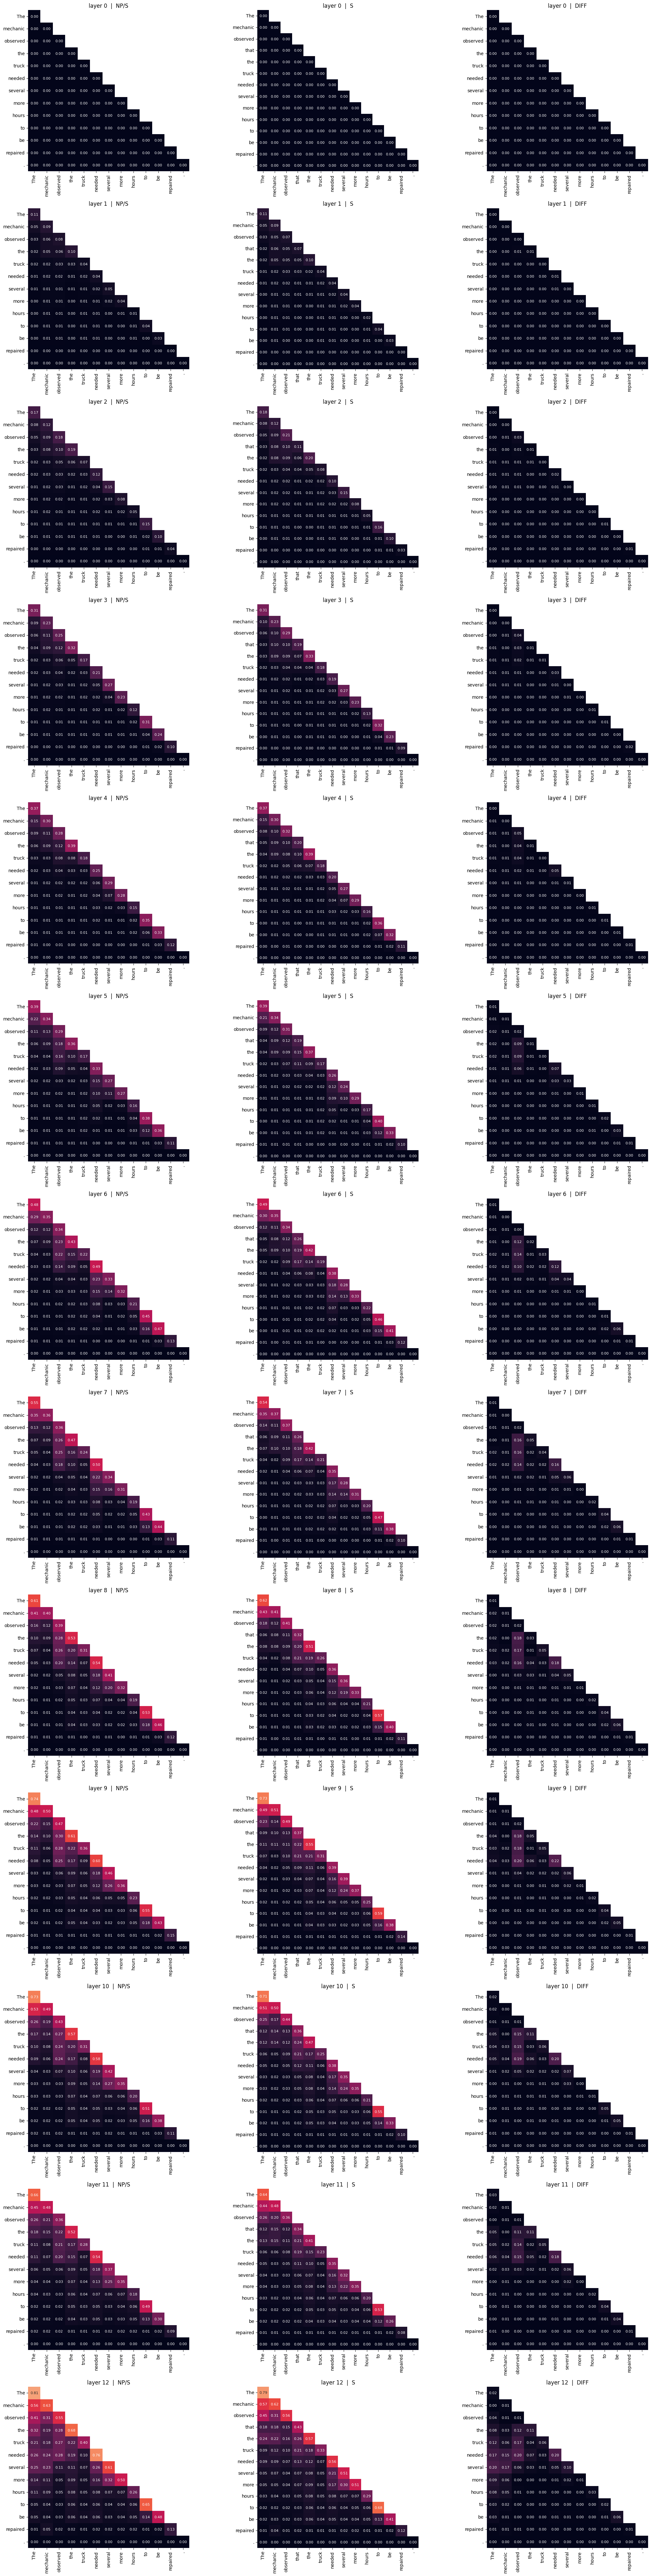

In [17]:
IDX = 309

fig, axs = plt.subplots(13, 3, figsize=(22, 80))

for layer, ax in zip(range(N_LAYERS), axs):

    sns.heatmap(nps_stimuli_triangles[layer][IDX], ax=ax[0],
                xticklabels=nps_df.loc[IDX].stimulus.split(),
                yticklabels=nps_df.loc[IDX].stimulus.split(),
                annot=True, fmt='.2f', annot_kws={"fontsize":8},
                vmax=1,
                square=True, cbar=False) 

    sns.heatmap(nps_baseline_triangles[layer][IDX], ax=ax[1],
                xticklabels=nps_df.loc[IDX].baseline.split(),
                yticklabels=nps_df.loc[IDX].baseline.split(),
                annot=True, fmt='.2f', annot_kws={"fontsize":8},
                vmax=1,
                square=True, cbar=False) 
                
    sns.heatmap(nps_diffs[layer][IDX], ax=ax[2],
                xticklabels=nps_df.loc[IDX].stimulus.split(),
                yticklabels=nps_df.loc[IDX].stimulus.split(),
                annot=True, fmt='.2f', annot_kws={"fontsize":8},
                vmax=1,
                square=True, cbar=False) 

    ax[0].set_title(f'layer {layer}  |  NP/S')
    ax[1].set_title(f'layer {layer}  |  S')
    ax[2].set_title(f'layer {layer}  |  DIFF')

plt.tight_layout()
plt.show()

Plot the averages. We start at the noun, because some sentences begin with DET ADJ N and others with DET N. The we plot the region of interest and its following tokens.

Observe average behaviour on the temporary ambiguous:

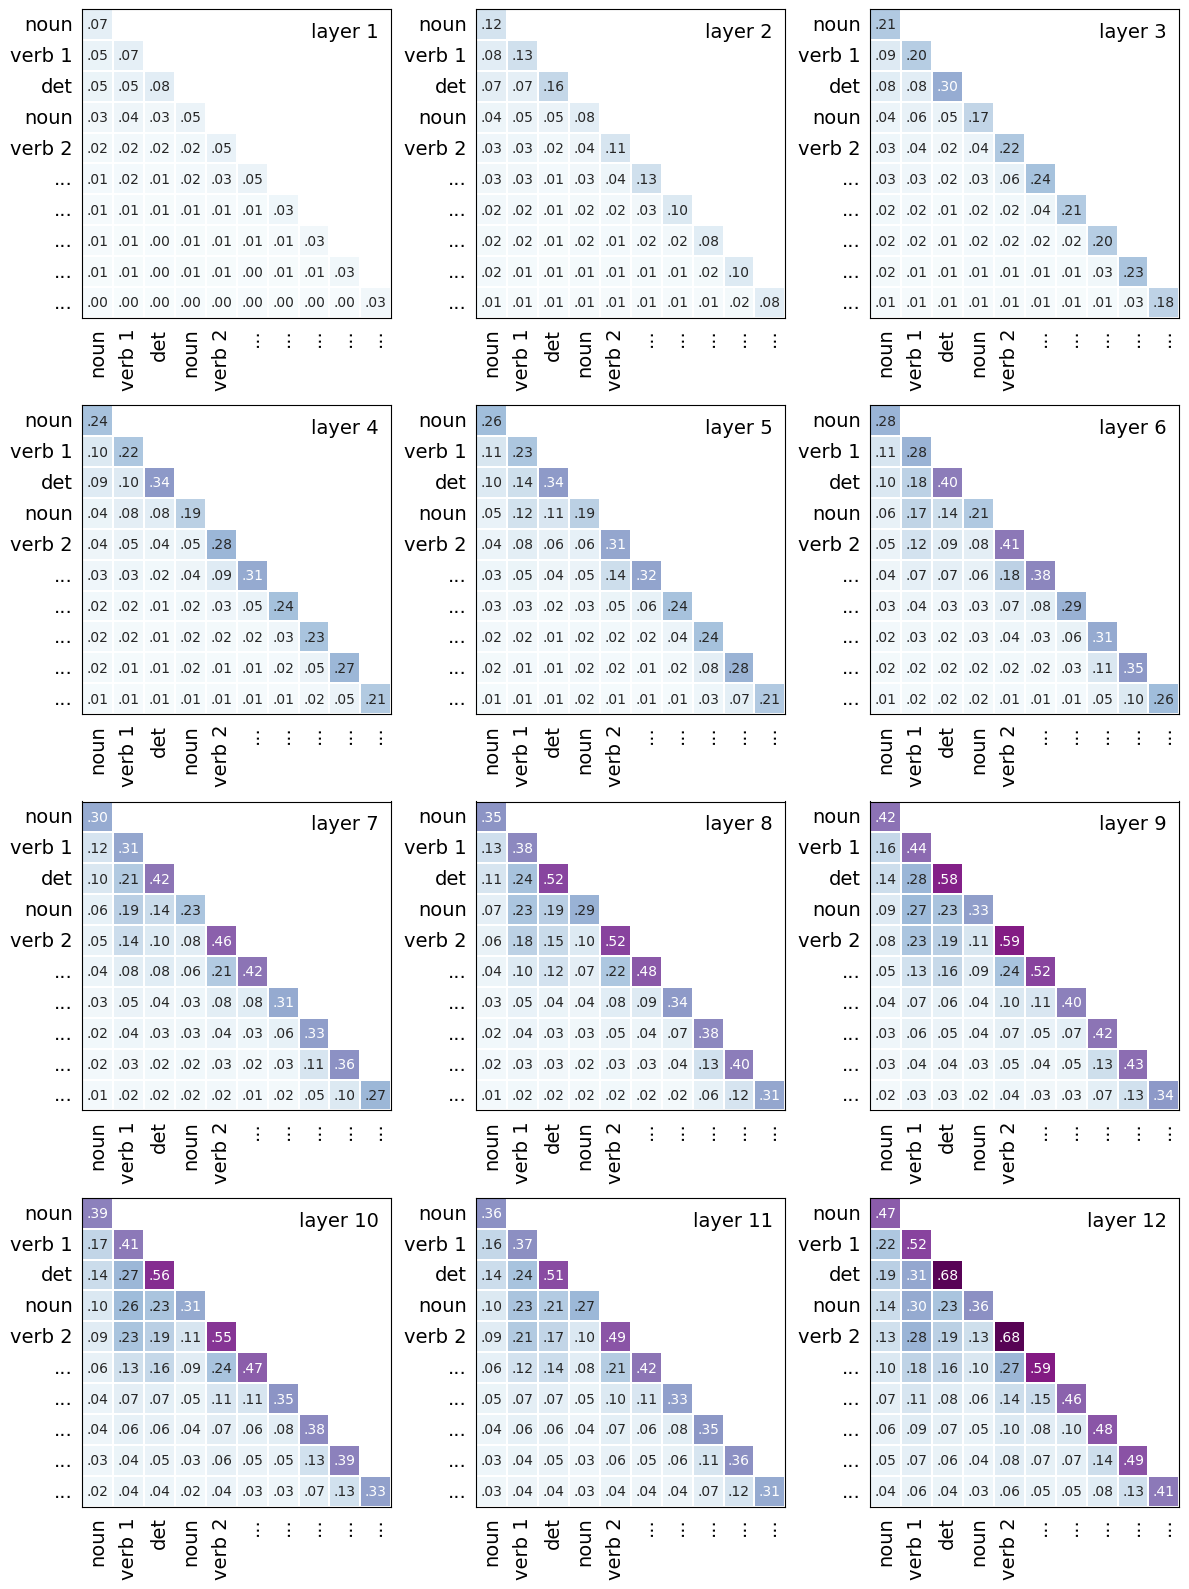

In [18]:
fig, axs = plt.subplots(4, 3, figsize=(12, 16))
vmax = 0.7 if MODEL == 'bert' else 0.15
 
for layer, ax in zip(range(1, N_LAYERS), axs.flatten()):

    # start one token before the main verb, i.e. the noun
    cropped_charts = [crop_chart(chart, begin=int(nps_df.loc[idx].amb_position_ambiguous) - 1)
                      for idx, chart in nps_stimuli_triangles[layer].items()]

    all_dists = np.vstack(cropped_charts)
    means = pd.DataFrame(np.mean(all_dists, axis=0))

    # from https://stackoverflow.com/a/77509198
    # remove trailing 0 to improve visualisation
    annot = means.apply(lambda col: [f'{v:.2f}'[-3:] for v in col], axis=0)

    sns.heatmap(means,
                xticklabels=COLS,
                yticklabels=COLS,
                square=True,
                cbar=False,
                cmap="BuPu",
                linewidths=0.1,
                vmin=0, vmax=vmax,
                annot=annot,
                fmt='',
                ax=ax)

    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(left=False, bottom=False)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    ax.set_title(f'layer {layer}  ' , pad=-20, fontsize=14, loc='right')
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)

plt.tight_layout()  
plt.show()

Now observe the average difference wrt to the unambiguous case:

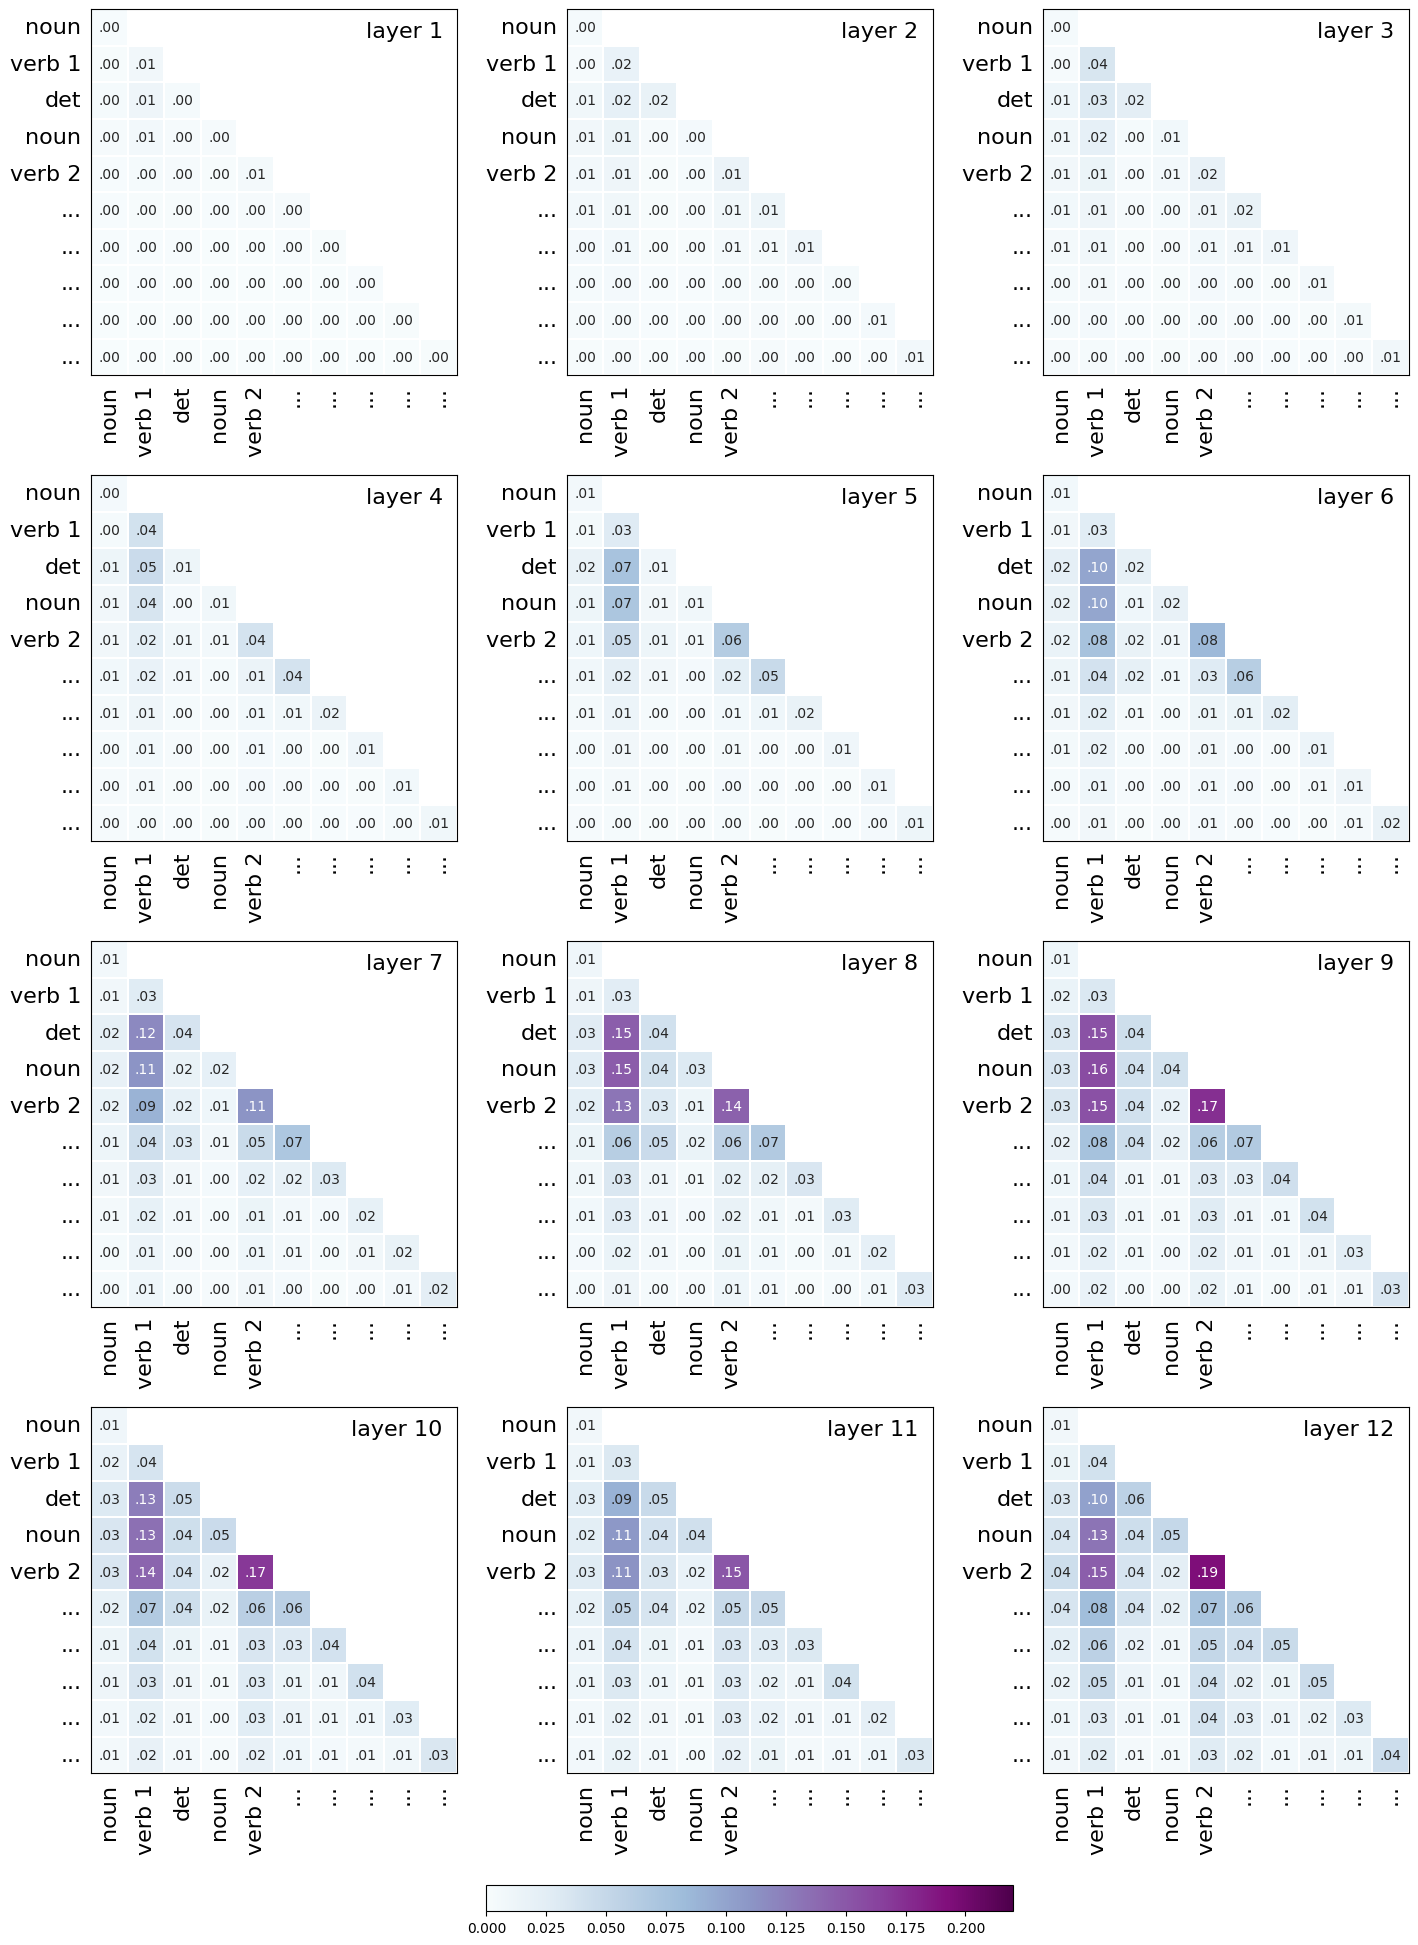

In [19]:
fig, axs = plt.subplots(4, 3, figsize=(17, 29))
plt.subplots_adjust(wspace=0.3)
vmax = 0.22 if MODEL == 'bert' else 0.07
 
for layer, ax in zip(range(1, N_LAYERS), axs.flatten()):

    # start one token before the main verb, i.e. the noun
    cropped_charts = [crop_chart(chart, begin=int(nps_df.loc[idx].amb_position_ambiguous) - 1)
                      for idx, chart in nps_diffs[layer].items()]

    all_dists = np.vstack(cropped_charts)
    means = pd.DataFrame(np.mean(all_dists, axis=0))

    # from https://stackoverflow.com/a/77509198
    # remove trailing 0 to improve visualisation
    annot = means.apply(lambda col: [f'{v:.2f}'[-3:] for v in col], axis=0)

    g = sns.heatmap(means,
                    xticklabels=COLS,
                    yticklabels=COLS,
                    square=True,
                    cbar=False,
                    cmap="BuPu",
                    linewidths=0.1,
                    vmin=0, vmax=vmax,
                    annot=annot,
                    fmt='',
                    ax=ax)

    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(left=False, bottom=False)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    ax.set_title(f'layer {layer}  ' , pad=-20, fontsize=16, loc='right')
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

mappable = g.get_children()[0]
fig.colorbar(mappable, ax=axs, orientation="horizontal", shrink=0.4, pad=0.05)

#plt.tight_layout() 
plt.savefig(f'./figures/nps-overview_{MODEL}_{NPS_REFERENCE}_{METRIC}.pdf', bbox_inches='tight')  
plt.show()

One layer for the main paper:

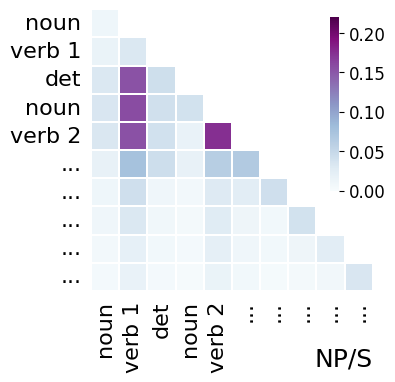

In [20]:
cropped_charts = [crop_chart(chart, begin=int(nps_df.loc[idx].amb_position_ambiguous) - 1)
                  for idx, chart in nps_diffs[SELECTED_LAYER].items()]

all_dists = np.vstack(cropped_charts)
means = pd.DataFrame(np.mean(all_dists, axis=0))

fig, ax = plt.subplots(figsize=(4, 4))
vmax = 0.22 if MODEL == 'bert' else 0.07

sns.heatmap(means,
            xticklabels=COLS,
            yticklabels=COLS,
            square=True,
            cbar=True,
            cmap="BuPu",
            linewidths=0.1,
            vmin=0, vmax=vmax,
            cbar_kws={'shrink': 0.6, "pad":-0.15, "anchor": (0, 0.9)},
            #annot=True,
            fmt='.2f')
plt.yticks(rotation=0)
ax.tick_params(left=False, bottom=False)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.xlabel('NP/S' , labelpad=-18, fontsize=18, loc='right')

ax.figure.axes[-1].tick_params(labelsize=12)

plt.tight_layout()
plt.savefig(f'./figures/nps-gp-effect_{MODEL}_{NPS_REFERENCE}_{METRIC}_layer{SELECTED_LAYER}.pdf', bbox_inches='tight')
plt.show()

### MVRR

In [21]:
mvrr_df = data_df[data_df.source=='classic-mvrr']
mvrr_prisms, mvrr_triangles = get_prisms_triangles('classic-mvrr')
mvrr_objs = get_objects('classic-mvrr', mvrr_df, mvrr_prisms, mvrr_triangles, MVRR_REFERENCE)

In [22]:
mvrr_stimuli_triangles = {i: {} for i in range(N_LAYERS)}
mvrr_baseline_triangles = {i: {} for i in range(N_LAYERS)}
mvrr_diffs = {i: {} for i in range(N_LAYERS)}

for idx, objs in mvrr_objs.items():
    obj_stimulus = objs['stimulus']
    obj_baseline = objs['baseline']

    for layer in range(N_LAYERS):
        stimulus_chart = obj_stimulus.get_mode_layer_chart(MVRR_REFERENCE, layer)
        baseline_chart = obj_baseline.get_mode_layer_chart(MVRR_REFERENCE, layer)

        baseline_short_chart = obj_baseline.get_mode_layer_chart(
            MVRR_REFERENCE, layer, remove_additions=True)
        diff = get_diff(stimulus_chart, baseline_short_chart)

        mvrr_stimuli_triangles[layer][idx] = stimulus_chart
        mvrr_baseline_triangles[layer][idx] = baseline_chart
        mvrr_diffs[layer][idx] = diff

In [23]:
for idx, row in mvrr_df.iterrows():
    print(idx, len(row.stimulus.split()), row.stimulus)

283 13 The suspect sent the file deserved further investigation given the new evidence .
287 13 The corrupt politician handed the bill received unwelcome attention from southern voters .
291 15 The woman brought the mail disappeared mysteriously after reading the bad news in it .
295 15 The boy fed the chicken stayed surprisingly happy despite having a mild allergic reaction .
299 15 The new doctor offered the operation appeared increasingly likely to succeed in her career .
303 12 The professor awarded the grant gained more attention from marine biologists .
307 13 The technician refused the service stopped working almost immediately after the argument .
311 14 The mechanic brought the truck needed several more hours to fully repair it .
315 13 The guitarist assigned the song failed dramatically because he never practiced enough .
319 16 The player paid the bonus remained essentially the same despite his sudden fame and wealth .
323 14 The recent hire offered the job prepared many stu

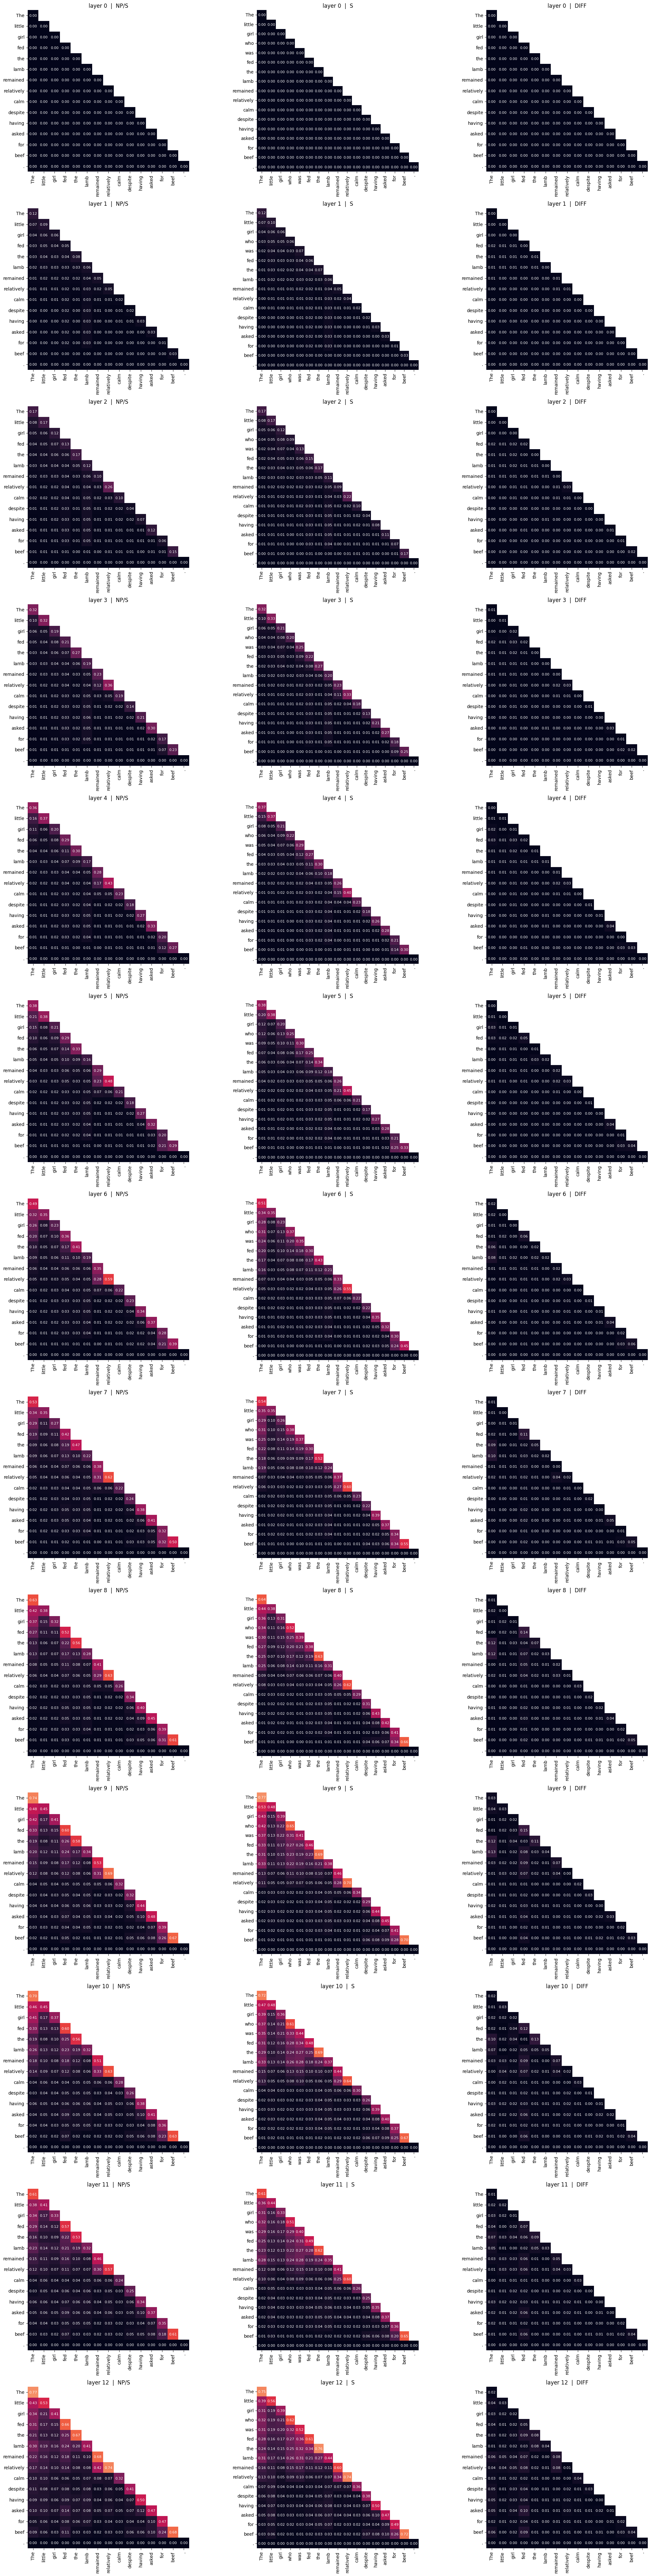

In [24]:
IDX = 343

fig, axs = plt.subplots(13, 3, figsize=(22, 80))

for layer, ax in zip(range(N_LAYERS), axs):

    sns.heatmap(mvrr_stimuli_triangles[layer][IDX], ax=ax[0],
                xticklabels=mvrr_df.loc[IDX].stimulus.split(),
                yticklabels=mvrr_df.loc[IDX].stimulus.split(),
                annot=True, fmt='.2f', annot_kws={"fontsize":8},
                vmax=1,
                square=True, cbar=False) 

    sns.heatmap(mvrr_baseline_triangles[layer][IDX], ax=ax[1],
                xticklabels=mvrr_df.loc[IDX].baseline.split(),
                yticklabels=mvrr_df.loc[IDX].baseline.split(),
                annot=True, fmt='.2f', annot_kws={"fontsize":8},
                vmax=1,
                square=True, cbar=False) 
                
    sns.heatmap(mvrr_diffs[layer][IDX], ax=ax[2],
                xticklabels=mvrr_df.loc[IDX].stimulus.split(),
                yticklabels=mvrr_df.loc[IDX].stimulus.split(),
                annot=True, fmt='.2f', annot_kws={"fontsize":8},
                vmax=1,
                square=True, cbar=False) 

    ax[0].set_title(f'layer {layer}  |  NP/S')
    ax[1].set_title(f'layer {layer}  |  S')
    ax[2].set_title(f'layer {layer}  |  DIFF')

plt.tight_layout()
plt.show()

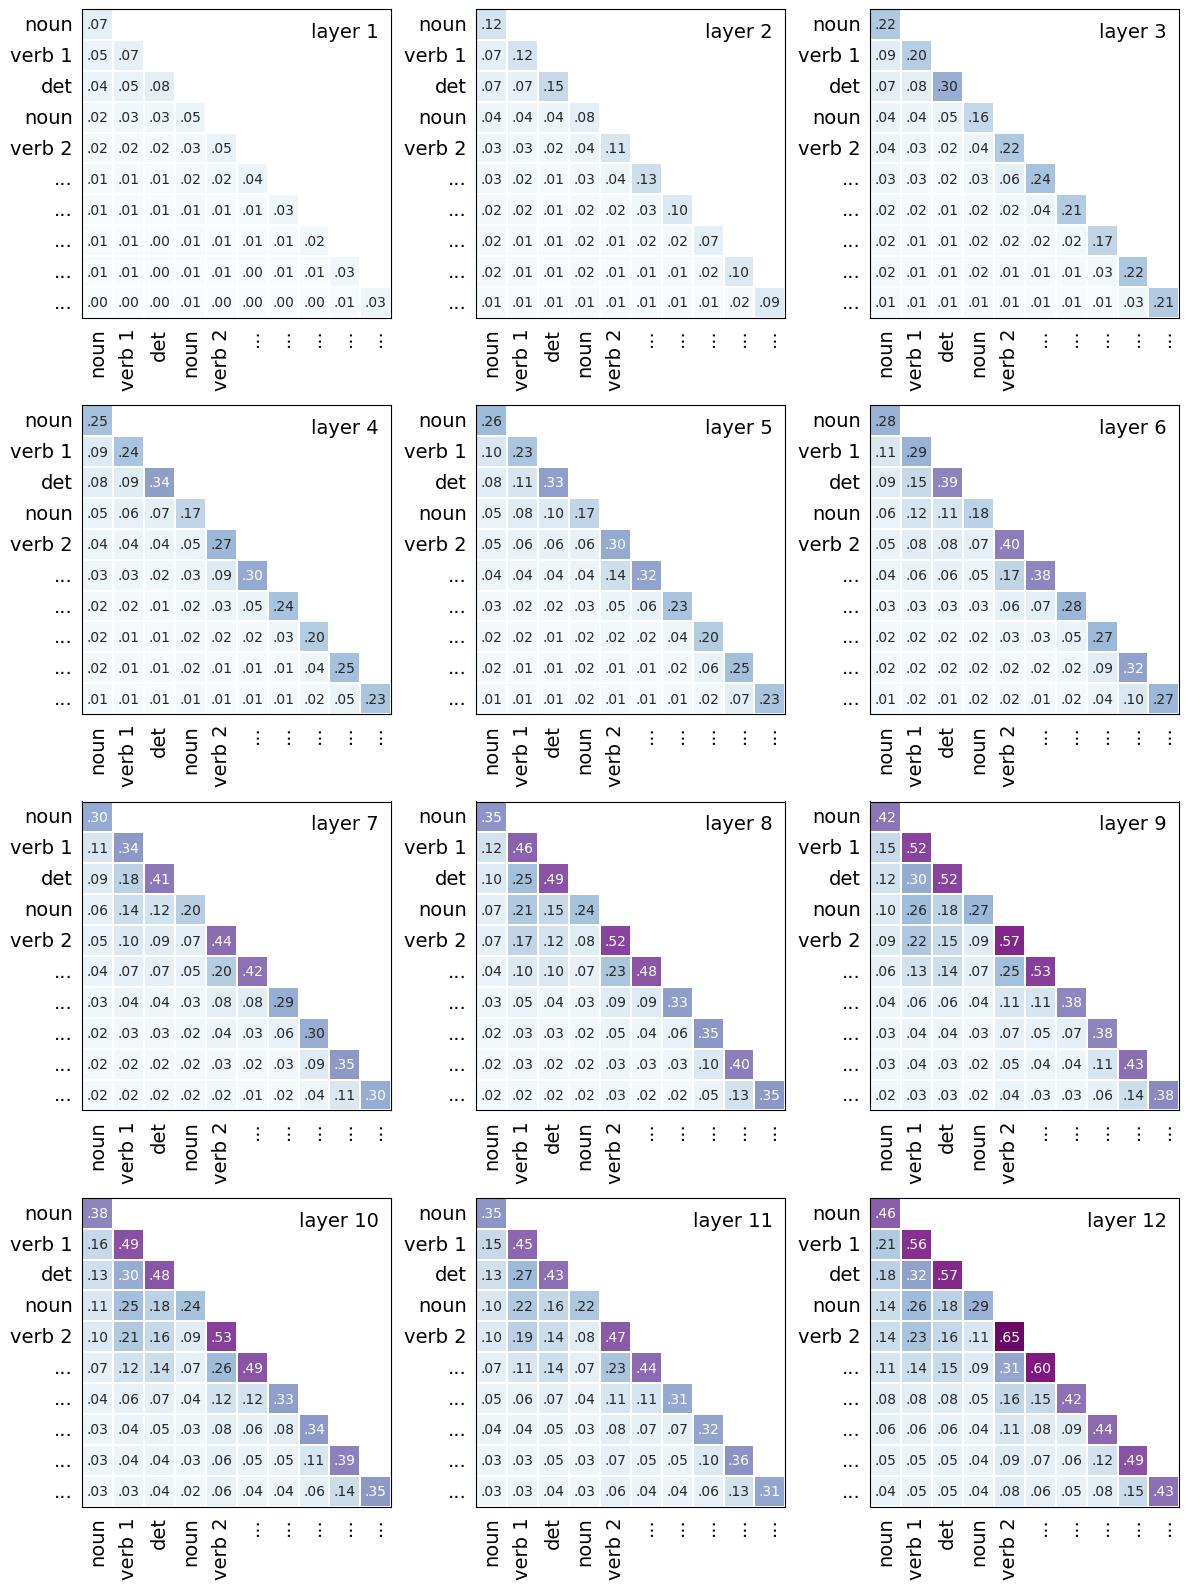

In [25]:
fig, axs = plt.subplots(4, 3, figsize=(12, 16))
vmax = 0.7 if MODEL == 'bert' else 0.15
 
for layer, ax in zip(range(1, N_LAYERS), axs.flatten()):

    # start one token before the main verb, i.e. the noun
    cropped_charts = [crop_chart(chart, begin=int(mvrr_df.loc[idx].amb_position_ambiguous) - 1)
                      for idx, chart in mvrr_stimuli_triangles[layer].items()]

    all_dists = np.vstack(cropped_charts)
    means = pd.DataFrame(np.mean(all_dists, axis=0))

    # from https://stackoverflow.com/a/77509198
    # remove trailing 0 to improve visualisation
    annot = means.apply(lambda col: [f'{v:.2f}'[-3:] for v in col], axis=0)

    sns.heatmap(means,
                xticklabels=COLS,
                yticklabels=COLS,
                square=True,
                cbar=False,
                cmap="BuPu",
                linewidths=0.1,
                vmin=0, vmax=vmax,
                annot=annot,
                fmt='',
                ax=ax)

    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(left=False, bottom=False)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    ax.set_title(f'layer {layer}  ' , pad=-20, fontsize=14, loc='right')
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)

plt.tight_layout()  
plt.show()

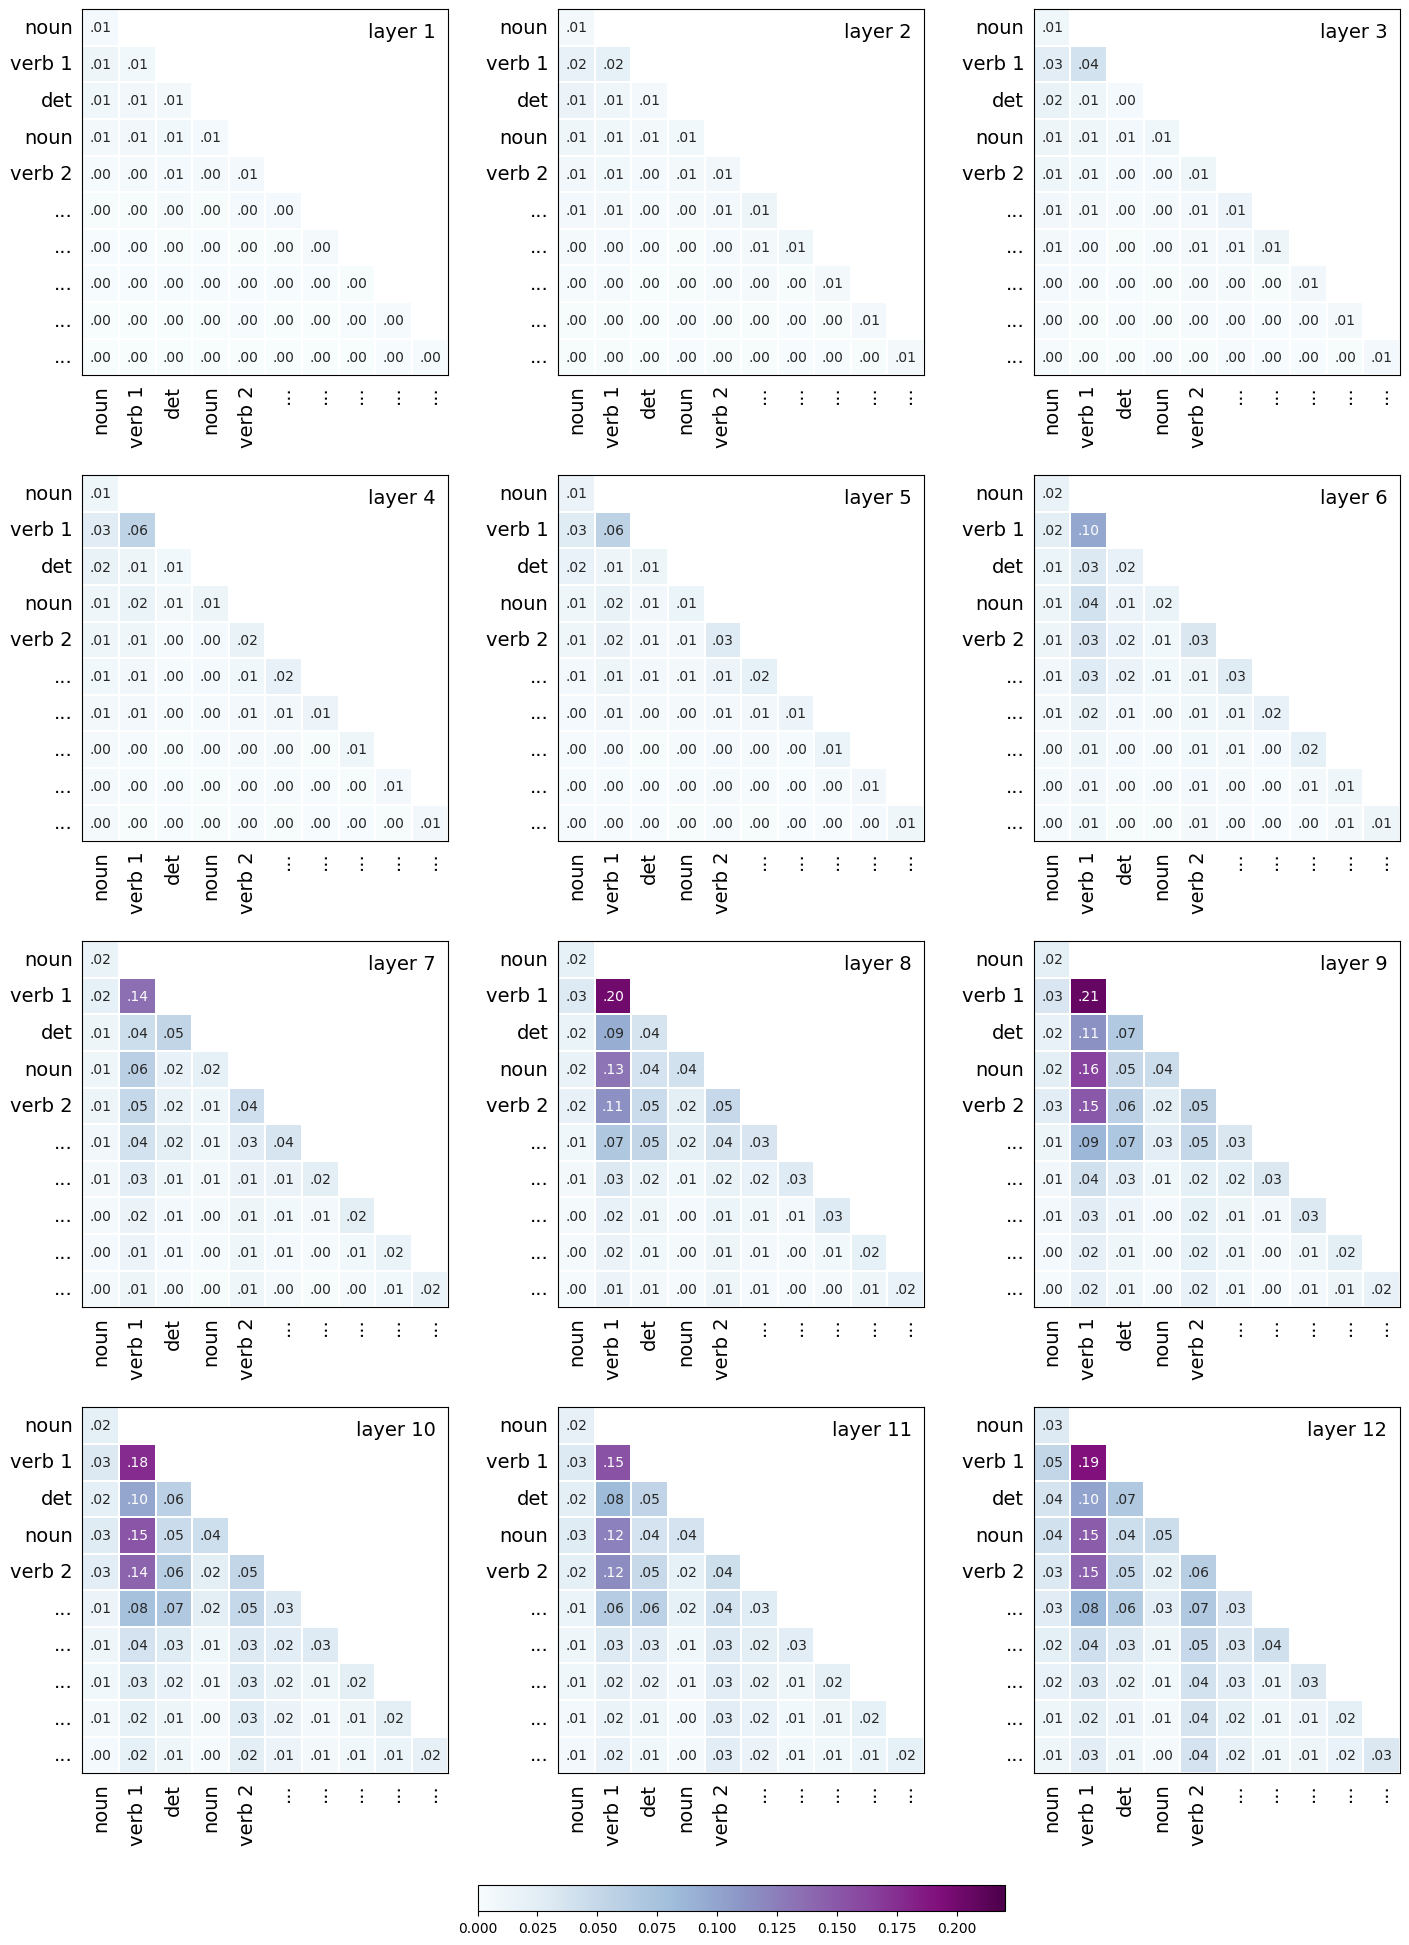

In [26]:
fig, axs = plt.subplots(4, 3, figsize=(17, 29))
plt.subplots_adjust(wspace=0.3)
vmax = 0.22 if MODEL == 'bert' else 0.07
 
for layer, ax in zip(range(1, N_LAYERS), axs.flatten()):

    # start one token before the main verb, i.e. the noun
    cropped_charts = [crop_chart(chart, begin=int(mvrr_df.loc[idx].amb_position_ambiguous) - 1)
                      for idx, chart in mvrr_diffs[layer].items()]

    all_dists = np.vstack(cropped_charts)
    means = pd.DataFrame(np.mean(all_dists, axis=0))

    # from https://stackoverflow.com/a/77509198
    # remove trailing 0 to improve visualisation
    annot = means.apply(lambda col: [f'{v:.2f}'[-3:] for v in col], axis=0)

    g = sns.heatmap(means,
                    xticklabels=COLS,
                    yticklabels=COLS,
                    square=True,
                    cbar=False,
                    cmap="BuPu",
                    linewidths=0.1,
                    vmin=0, vmax=vmax,
                    annot=annot,
                    fmt='',
                    ax=ax)

    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(left=False, bottom=False)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    ax.set_title(f'layer {layer}  ' , pad=-20, fontsize=14, loc='right')
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)

mappable = g.get_children()[0]
fig.colorbar(mappable, ax=axs, orientation="horizontal", shrink=0.4, pad=0.05)

#plt.tight_layout() 
plt.savefig(f'./figures/mvrr-overview_{MODEL}_{MVRR_REFERENCE}_{METRIC}.pdf', bbox_inches='tight')  
plt.show()

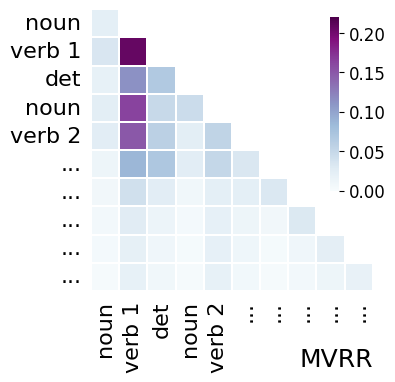

In [27]:
cropped_charts = [crop_chart(chart, begin=int(mvrr_df.loc[idx].amb_position_ambiguous) - 1)
                    for idx, chart in mvrr_diffs[SELECTED_LAYER ].items()]

all_dists = np.vstack(cropped_charts)
means = pd.DataFrame(np.mean(all_dists, axis=0))

fig, ax = plt.subplots(figsize=(4, 4))
vmax = 0.22 if MODEL == 'bert' else 0.07

sns.heatmap(means,
            xticklabels=COLS,
            yticklabels=COLS,
            square=True,
            cbar=True,
            cmap="BuPu",
            linewidths=0.1,
            vmin=0, vmax=vmax,
            cbar_kws={'shrink': 0.6, "pad":-0.15, "anchor": (0, 0.9)},
            #annot=True,
            fmt='.2f')
plt.yticks(rotation=0)
ax.tick_params(left=False, bottom=False)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.xlabel('MVRR' , labelpad=-18, fontsize=18, loc='right')

ax.figure.axes[-1].tick_params(labelsize=12)

plt.tight_layout()
plt.savefig(f'./figures/mvrr-gp-effect_{MODEL}_{MVRR_REFERENCE}_{METRIC}_layer{SELECTED_LAYER}.pdf', bbox_inches='tight')
plt.show()